In [1]:
from pathlib import Path  
import numpy as np
import pandas as pd
import datetime
import joblib
import optuna
import pickle
import time
import glob
import csv
import os

# GPU-based frameworks
import cudf
import cupy as cp
from cuml.ensemble import RandomForestClassifier as cuRFC

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import f1_score


#  MODIS Water Cluster Training

Version: 0.1.0

Date modified: 05.01.2023

Modified by: Amanda Burke

## Parameters

Changing these are the most important

In [2]:
## VERSION 4.2.1 (targeted 500k points)
# DATASET_VERSION = 'v421'
## VERSION 2.0.1 (5 million points)
DATASET_VERSION = 'v201'
## VERSION 0.0.0 (2billion data points)
# DATASET_VERSION = 'v000'

## No clustering to rf
# CLUSTER_MODELS = ['Nocluster']
## Proportional or even balance clustering to rf
CLUSTER_MODELS = [
    # 'EBmatch' #,
    #'EBcluster',
    #'Pmatch',
    'Pcluster'
        ]

## Variables input to the rf
input_vars = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b07_1','ndvi']

calc_NDVI = False

# What type of processor to use
# PROCESSOR = 'gpu'
PROCESSOR = 'cpu'
    

In [3]:
TEST_RATIO = 0.2
v_names = [
    'sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
    'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
    'sur_refl_b07_1','ndvi','ndwi1','ndwi2'
    ]
common_params = {
    "n_init": "auto"
}
droped_vars = [v for v in v_names if v not in input_vars]
#RF Training
search_space={
    "n_estimators": [75, 100, 125, 150, 175, 200, 250, 300, 400, 500],
    "max_depth" : [5, 10, 30, 50, 80, 90, 100, 110],
    "min_samples_leaf" : [1, 2, 3, 4, 5],
    "min_samples_split" : [2, 4, 8, 10],
    "bootstrap" : [True, False],
    "max_features" : ['auto', 'sqrt', 'log2'] 
}
bin_boundaries =  [*range(-10000,0,1000)] + [*range(0,10001,1000)]

## Functions

### Plotting

In [4]:
def plotting_clusters(X_w,X_l,cluster_output_w,cluster_output_l, n_cluster,
                      kme_w=None,kme_l=None):
    fig = plt.figure(figsize = (25, 10))

    plt.suptitle(f'Kmeans Clustering {DATA_VERSION} Data, {n_cluster} Clusters')

    ax1 = plt.subplot(131)
    ax1.set_title(f'Land and Water Datapoints')
    ax1.scatter(X_w.values[:,0], X_w.values[:,1],label='Water')
    ax1.scatter(X_l.values[:,0], X_l.values[:,1],label='Land')
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.tick_params(axis='both', which='minor', labelsize=10)
    ax1.set_xlabel(X_w.columns[0])
    ax1.set_ylabel(X_w.columns[1])
    ax1.legend(loc='lower right',fontsize="20")

    ax2 = plt.subplot(132)
    ax2.set_title(f'Water Datapoints Clustered: {len(X_water)} Examples')
    ax2.scatter(X_w.values[:,0], X_w.values[:,1],c=cluster_output_w,cmap='tab10')
    if kme_w is not None:
        ax2.scatter(kme_w.cluster_centers_[:,0],kme_w.cluster_centers_[:,1],
            label='Center Point',c='k',s=150)
        ax2.legend(loc='lower right',fontsize="20")
    ax2.tick_params(axis='both', which='major', labelsize=10)
    ax2.tick_params(axis='both', which='minor', labelsize=10)
    ax2.set_xlabel(X_w.columns[0])
    ax2.set_ylabel(X_w.columns[1])
    

    ax3 = plt.subplot(133)
 
    ax3.set_title(f'Land Datapoints Clustered: {len(X_land)} Examples')
    ax3.scatter(X_l.values[:,0], X_l.values[:,1],c=cluster_output_l,cmap='tab10')
    if kme_l is not None:
        ax3.scatter(kme_l.cluster_centers_[:,0],kme_l.cluster_centers_[:,1],
                    label='Center Point',c='k',s=150)
        ax3.legend(loc='lower right',fontsize="20")
    ax3.tick_params(axis='both', which='major', labelsize=10)
    ax3.tick_params(axis='both', which='minor', labelsize=10)
    ax3.set_xlabel(X_l.columns[0])
    ax3.set_ylabel(X_l.columns[1])
   
    plt.show()
    plt.close()

### Loading and extracting data

In [5]:
def cpu_load_data(fpath, colsToDrop, 
    yCol='water', testSize=0.2, randomState=42,
    dataType=np.int16, cpu=True, splitXY=True, trainTestSplit=True,
    applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
    multisample=1000000, ndvi_change=calc_NDVI):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for
                   path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]

    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        if land:
            print('Imbalancing data, sampling {} from water'.format(frac))
        else:
            print(f'Imbalancing data, sampling {frac} from land, {1-frac} from water')
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    cleanedX = cleanedDF.drop([yCol], axis=1).astype(dataType)
    cleanedy = cleanedDF[yCol].astype(dataType)
    
    ############
    #Added calculation of NDVI instead of the file point
    ############
    if ndvi_change is True:
        top_math_ndvi = (cleanedX['sur_refl_b02_1'].values - cleanedX['sur_refl_b01_1'].values)
        bot_math_ndvi = (cleanedX['sur_refl_b02_1'].values + cleanedX['sur_refl_b01_1'].values)
        calculated_ndvi = top_math_ndvi/bot_math_ndvi
        calculated_ndvi[calculated_ndvi > 1.0] = 1.0
        calculated_ndvi[calculated_ndvi < -1.0] = -1.0
        scaled_ndvi = (10000*calculated_ndvi).astype(int)
        cleanedX['new_ndvi'] = scaled_ndvi
        
    if trainTestSplit:
        return train_test_split(cleanedX, cleanedy, test_size=TEST_RATIO)
    else:
        return cleanedX, cleanedy

In [6]:
def gpu_load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
            dataType=cp.float32, cpu=False, splitXY=True, trainTestSplit=True,
            applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
            multisample=1000000, ndvi_change=calc_NDVI):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    cleanedDF = cudf.from_pandas(cleanedDF) if not cpu else cleanedDF
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        if land:
            print('Imbalancing data, sampling {} from water'.format(frac))
        else:
            print('Imbalancing data, sampling {} from land'.format(frac))
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    
    cleanedX = cleanedDF.drop([yCol], axis=1).astype(dataType)
    cleanedy = cleanedDF[yCol].astype(dataType)
    
    ############
    #Added calculation of NDVI instead of the file point
    ############
    if ndvi_change is True:
        top_math_ndvi = (cleanedX['sur_refl_b02_1'].values - cleanedX['sur_refl_b01_1'].values)
        bot_math_ndvi = (cleanedX['sur_refl_b02_1'].values + cleanedX['sur_refl_b01_1'].values)
        calculated_ndvi = top_math_ndvi/bot_math_ndvi
        calculated_ndvi[calculated_ndvi > 1.0] = 1.0
        calculated_ndvi[calculated_ndvi < -1.0] = -1.0
        scaled_ndvi = (10000*calculated_ndvi).astype(int)
        cleanedX['ndvi'] = scaled_ndvi
    if trainTestSplit:
        return train_test_split(cleanedX, cleanedy, test_size=TEST_RATIO)
    else:
        return cleanedX, cleanedy

In [7]:
def pre_process_data(tile, data_version, offsets_indexes, 
                    ndvi_calc=calc_NDVI, colsToDrop=droped_vars):
    
    training_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{data_version}'
    glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(tile))
    data_paths = sorted([fv for fv in glob.glob(glob_string)])
 
    data_path = data_paths[0]
    print(data_path)

    colsToDropTraining = colsToDrop.copy()
    colsToDropTraining.extend(offsets_indexes)
    
    if 'gpu' in PROCESSOR:
        X_gpu, X_test, y_gpu, y_test = gpu_load_data(
            fpath=data_path,
            colsToDrop=colsToDropTraining
            )
        X_cpu, X_test, y_cpu, y_test = cpu_load_data(
            fpath=data_path,
            colsToDrop=colsToDropTraining
            )
        print('Input Variables', X_cpu.columns)
        print(f'data shape: {X_cpu.shape}, {y_cpu.shape}')
        return X_gpu, y_gpu, X_cpu, y_cpu
    else: 
        X, X_test, y, y_test = cpu_load_data(
            fpath=data_path,
            colsToDrop=colsToDropTraining
            )
        print('Input Variables', X.columns)
        print(f'data shape: {X.shape}, {y.shape}')
        
    #Getting the indices that are associated with land (0) and water (1)
    water_indx = np.where(y>0.5)[0]
    land_indx = np.where(y<0.5)[0]
    # print(y.iloc[water_indx])
    # print('Min water value:',np.nanmin(y.iloc[water_indx]),', Min land value:',np.nanmin(y.iloc[land_indx]))
    print()

    return X, y, water_indx, land_indx

### Kmeans Clustering and Matching Size dataset

Based on the cluster analysis above on 5.03.23, 15 clusters appears to have the most data and exclude outliers so will use that number for selection 

In [8]:
def kmeans_clustering(cluster_type, InX, InY, water_i, land_i, 
    kwargs=common_params, plotting=False, CLUSTER_NUM=15, 
    PERCENT_RANDOM_PULL=0.15, match=True):

    InY_w = InY.iloc[water_i].reset_index(drop=True)
    InY_l = InY.iloc[land_i].reset_index(drop=True)
    InX_w = InX.iloc[water_i].reset_index(drop=True)
    InX_l = InX.iloc[land_i].reset_index(drop=True)
    
    kme_land_model = MiniBatchKMeans(n_clusters=CLUSTER_NUM, **kwargs).fit(InX_l)
    kme_land = kme_land_model.predict(InX_l)

    kme_water_model = MiniBatchKMeans(n_clusters=CLUSTER_NUM, **kwargs).fit(InX_w)
    kme_water = kme_water_model.predict(InX_w)
    
    if plotting:
        plotting_clusters(
                    InX_w, InX_l,
                    kme_water,kme_land,
                    CLUSTER_NUM,kme_water_model,kme_land_model)
    if 'Even' in cluster_type: 
        eb_count_water  = np.inf
        eb_count_land = np.inf
        for c in np.arange(CLUSTER_NUM):
            water_num = len(np.where(kme_water == c)[0])
            if water_num < eb_count_water: eb_count_water = water_num
            land_num = len(np.where(kme_land == c)[0])
            if land_num < eb_count_land: eb_count_land = land_num
        if eb_count_land < eb_count_water: COUNT = eb_count_land
        else: COUNT = eb_count_water
    
    w_l_cluster_indx = []
    for label in [kme_water,kme_land]:
        cluster_indx = []
        for c in np.arange(CLUSTER_NUM):
            indx = np.where(label == c)[0]  
            if 'Even' in cluster_type: selection_count = COUNT
            else: selection_count = int(PERCENT_RANDOM_PULL*len(indx))
            rand_indx = np.random.choice(indx,selection_count,replace=False)
            cluster_indx.extend(list(rand_indx))
        w_l_cluster_indx.append(cluster_indx)
    
    clusterY = pd.concat(
        [InY_w.iloc[w_l_cluster_indx[0]],InY_l.iloc[w_l_cluster_indx[1]]]
         ).reset_index(drop=True).sample(frac=1)
    clusterX = pd.concat(
        [InX_w.iloc[w_l_cluster_indx[0]],InX_l.iloc[w_l_cluster_indx[1]]]
         ).reset_index(drop=True).iloc[clusterY.index]
    if match is False:
        print("Using clustered data")
        return clusterX, clusterY
    else:
        print("Using Randomly Matched Data")
        matchY_w = InY_w.sample(n=len(w_l_cluster_indx[0]),replace=False)
        matchY_l = InY_l.sample(n=len(w_l_cluster_indx[1]),replace=False)
    
        matchY = pd.concat([matchY_w,matchY_l]).reset_index(drop=True).sample(frac=1)  
        matchX = pd.concat(
            [InX_w.iloc[matchY_w.index], InX_l.iloc[matchY_l.index]]
            ).reset_index(drop=True).iloc[matchY.index]
        return matchX, matchY

### Running the Data Preprocessing 

In [9]:
%%time
if '201' in DATASET_VERSION: 
    pre_process_params = {
        'tile':'GLOBAL',
        'data_version':'v2.0.1',
        'offsets_indexes': ['x_offset','y_offset','year','julian_day']}
if '421' in DATASET_VERSION:
    pre_process_params = {
        'tile':'Golden',
        'data_version':'v4.2.1',
        'offsets_indexes': ['x_offset','y_offset','year','julian_day','tileID']}
if '000' in DATASET_VERSION:
    pre_process_params = {
        'tile':'cleaned',
        'data_version':'AGU',
        'offsets_indexes': []} 
if 'gpu' in PROCESSOR:
    X_gpu, y_gpu, X_cpu, y_cpu = pre_process_data(**pre_process_params)
else: 
    X_cpu, y_cpu, water_indx, land_indx = pre_process_data(**pre_process_params)

/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v2.0.1/MOD09_GLOBAL_5469777_2_0_1.parquet.gzip
Input Variables Index(['sur_refl_b01_1', 'sur_refl_b02_1', 'sur_refl_b07_1', 'ndvi'], dtype='object')
data shape: (4375821, 4), (4375821,)

CPU times: user 3.86 s, sys: 879 ms, total: 4.74 s
Wall time: 4.78 s


### Random Forest functions

In [10]:
def rf_objective(trial, rfaX, rfaY):
    list_trees = [75, 100, 125, 150, 175, 200, 250, 300, 400, 500]
    max_depth = [5, 10, 30, 50, 80, 90, 100, 110]
    min_samples_leaf = [1, 2, 3, 4, 5]
    min_samples_split = [2, 4, 8, 10]
    bootstrap = [True, False]
    max_features = ['auto', 'sqrt', 'log2']
    
    gpu_param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
        'max_depth':trial.suggest_categorical('max_depth', max_depth), 
        'min_samples_split':trial.suggest_categorical('min_samples_split', min_samples_split), 
        'min_samples_leaf':trial.suggest_categorical('min_samples_leaf', min_samples_leaf), 
        'max_features':trial.suggest_categorical('max_features', max_features), 
            }
    if 'gpu' in PROCESSOR: 
        avg_cv_scores = gpu_rf_objective(rfaX, rfaY, gpu_param)
    else:
        param = { 
            'max_leaf_nodes':None, 
            'min_impurity_decrease':0.0, 
            'oob_score':False, 
            'verbose':0, 
            'n_jobs': -1,
            'warm_start':False, 
            'class_weight':None, 
            'ccp_alpha':0.0, 
            'max_samples':None
                }
        cpu_param = {**gpu_param, **param}
        avg_cv_scores = cpu_rf_objective(rfaX, rfaY, cpu_param)
    
    return avg_cv_scores

In [11]:
def cpu_rf_objective(rfaX, rfaY, param):
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    cv_scores = np.empty(5)
    for idx, (train_idx, val_idx) in enumerate(cv.split(rfaX, rfaY)):
        X_train, X_val = rfaX.iloc[train_idx], rfaX.iloc[val_idx]
        y_train, y_val = rfaY.iloc[train_idx],  rfaY.iloc[val_idx]
        model = skRF(**param)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        cv_scores[idx] = f1_score(y_val, preds)
        if cv_scores[idx] == 0.0:
            print('Pruning because of 0.0 score.')
            return 0.0
    return np.mean(cv_scores)

In [12]:
def gpu_rf_objective(rfaX, rfaY, param):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = np.empty(5)
    for idx, (train_idx, val_idx) in enumerate(cv.split(rfaX.to_pandas(), rfaY.to_pandas())):
        X_train, X_val = rfaX.iloc[train_idx], rfaX.iloc[val_idx]
        y_train, y_val = rfaY.iloc[train_idx], rfaY.iloc[val_idx]
        model = cuRFC(**param)
        model.fit(X_train, 
                  y_train)
        preds = model.predict(X_val)
        cv_scores[idx] = f1_score(y_val.to_numpy(), preds.to_numpy())
        del model, preds
        if cv_scores[idx] == 0.0:
            print('Pruning because of 0.0 score.')
            return 0.0
        print('Fold {}: {}'.format(idx, cv_scores[idx]))
    return np.mean(cv_scores)

In [13]:
def running_rfa(rfaX, rfaY, num_trials=25):
    optuna.logging.set_verbosity(optuna.logging.INFO)
    study = optuna.create_study(
        study_name='RF Tuning Grid Search', direction='maximize',
        sampler=optuna.samplers.GridSampler(search_space))
    study.optimize(
            lambda trial: rf_objective(trial, rfaX, rfaY), 
            n_trials=num_trials, timeout=30*600
            )
    trials = study.best_trials            
    max_trial_score = max([trial.values[0] for trial in trials])
    max_trial_params = [trial.params for trial in trials 
                        if trial.values[0] == max_trial_score][0]
    max_trial_params['n_jobs'] = -1
    return max_trial_score, max_trial_params

### Running the RF Functions

In [17]:
num_iterations = 1
best_trial_data = {}
start_time = time.time()

if 'gpu' in PROCESSOR: 
    nocluster_score, nocluster_param = running_rfa(X_gpu, y_gpu,num_iterations)
    noc_round_score = int(np.round(nocluster_score,5)*10000)
    print(f'\n {noc_round_score}, {len(X_gpu)} Samples')
    nocluster_param['n_jobs'] = -1
    #RFA fitting
    nocluster_rfa = skRF(**nocluster_param)
    nocluster_rfa.fit(X_cpu,y_cpu)
    #Output rfa file
    noc_rfa_filename = f'rfa_models/MODIS_RFA_{DATASET_VERSION}_Nocluster_MaxScore{noc_round_score}_SfcRef127ndvi.pkl'
    print(f'Saving random forest to: {noc_rfa_filename}')
    pickle.dump(nocluster_rfa, open(noc_rfa_filename, 'wb'))
else: 
    kmeans_params = {'InX': X_cpu, 'InY': y_cpu, 'water_i': water_indx, 'land_i': land_indx}
    for cluster_type in CLUSTER_MODELS:
        print(f'\n{cluster_type}')
        best_score = 0
        for i in np.arange(num_iterations):
            print(f'Iteration: {i}')
            if 'cluster' in cluster_type: kmeans_params['match'] = False
            if 'EB' in cluster_type: kmeans_params['cluster_type'] = 'Even Balance'
            if 'P' in cluster_type: kmeans_params['cluster_type'] = 'Percent'

            rfa_pred, rfa_label = kmeans_clustering(**kmeans_params)
            tuning_score, rfa_param = running_rfa(rfa_pred, rfa_label)
            if tuning_score > best_score:
                best_label = rfa_label
                best_pred = rfa_pred
                best_param = rfa_param
                best_score = tuning_score
            else: continue 
            del rfa_pred, rfa_label, rfa_param, tuning_score
        #Save data for plotting
        best_trial_data[cluster_type] = pd.concat([best_pred,best_label],axis=1)
        #Print out best iteration info 
        round_score = int(np.round(best_score,5)*10000)
        print(f'\nMax score for {cluster_type}: {round_score}, {len(best_pred)} Samples')
        #RFA fitting
        best_rfa = skRF(**best_param)
        best_rfa.fit(best_pred,best_label)
        #Output rfa file
        rfa_filename = f'rfa_models/MODIS_RFA_{DATASET_VERSION}_{cluster_type}_MaxScore{round_score}_SfcRef127ndvi.pkl'
        print(f'Saving random forest to: {rfa_filename}')
        pickle.dump(best_rfa, open(rfa_filename, 'wb'))
        #Print out time length 
elapsed_time = time.time() - start_time
print(f'Execution time: {time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}\n')



Pcluster
Iteration: 0


[I 2023-10-24 10:43:46,324] A new study created in memory with name: RF Tuning Grid Search


Using clustered data


[I 2023-10-24 10:44:12,417] Trial 0 finished with value: 0.9767974877726144 and parameters: {'n_estimators': 100, 'max_depth': 90, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9767974877726144.
[I 2023-10-24 10:44:43,102] Trial 1 finished with value: 0.9766256812301041 and parameters: {'n_estimators': 125, 'max_depth': 110, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9767974877726144.
[I 2023-10-24 10:45:29,599] Trial 2 finished with value: 0.9767017064511583 and parameters: {'n_estimators': 200, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9767974877726144.
[I 2023-10-24 10:47:18,028] Trial 3 finished with value: 0.9769224242388084 and parameters: {'n_estimators': 500, 'max_depth': 100, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'auto'}. Best is trial 3 with value: 0.976922424238


Max score for Pcluster: 9773, 656360 Samples
Saving random forest to: rfa_models/MODIS_RFA_v201_Pcluster_MaxScore9773_SfcRef127ndvi.pkl
Execution time: 00:17:08



### Data Analysis

In [ ]:
not_same_point = X_cpu[(X_cpu['new_ndvi'] - X_cpu['ndvi']) != 0]

In [ ]:
not_same_nvdi_label = y_cpu[not_same_point.index]
print('Total num of data', len(y_cpu))
print('Num of bad data', len(not_same_nvdi_label))
print('Percent bad data',  len(not_same_nvdi_label)/len(y_cpu))
print('How many are water', np.count_nonzero(not_same_nvdi_label))
bad_land = len(not_same_nvdi_label) - np.count_nonzero(not_same_nvdi_label)
print('How many are land',bad_land)
print("Percent land",bad_land/np.count_nonzero(not_same_nvdi_label))

NameError: name 'not_same_point' is not defined

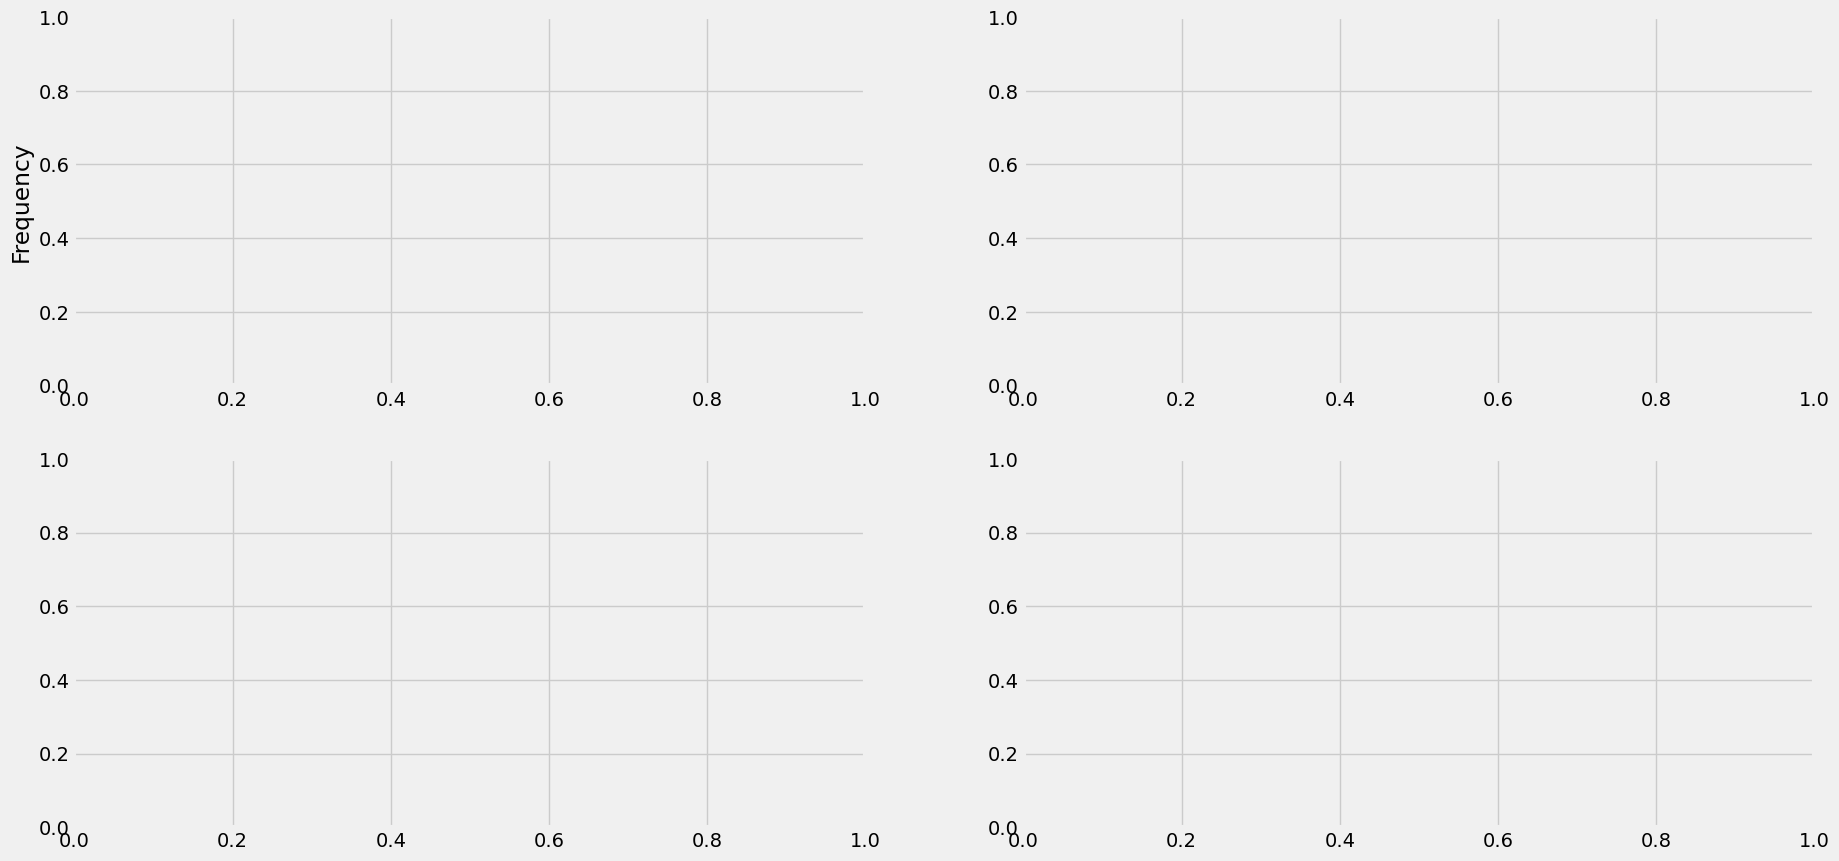

In [18]:
fig, ax = plt.subplots(2, 2,figsize=(20, 10))
var=0
for col in range(2):
    ax[col, 0].set_ylabel('Frequency') 
    for row in range(2):
        variable=X_cpu.columns[var]
        if 'ndvi' in variable: 
            continue
            var_bins = bin_boundaries
            log_values = False
        else: 
            var_bins = None
            log_values = True
        ax[row, col].hist(
            [   
            X_cpu[variable][not_same_point.index].values
            ],
            label=[
            "data"
            ],
            bins=var_bins,
        color=['brown'], log=log_values) 
        ax[row, col].set_xlabel(f'{variable}')
        var+=1
    ax[0,0].legend(loc='upper right',fontsize=20)
plt.show()

#### Plots

In [ ]:
print(best_trial_data)
['EBmatch','EBcluster','Pmatch','Pcluster']

In [ ]:
fig, ax = plt.subplots(2, 2,figsize=(20, 10))
var=0
for col in range(2):
    ax[col, 0].set_ylabel('Frequency') 
    for row in range(2):
        variable=v201_X.columns[var]
        if 'ndvi' in variable: 
            var_bins = bin_boundaries
            log_values = False
        else: 
            var_bins = None
            log_values = True
        ax[row, col].hist(
            [   
                v201_X[variable].values,
                best_trial_data['EBmatch'][variable].values,
                best_trial_data['EBcluster'][variable].values,
                best_trial_data['Pmatch'][variable].values,
                best_trial_data['Pcluster'][variable].values
            ],
            label=[
                #Change these
                'v2.0.1',
                'EB Match',
                'EB Cluster',
                'Percent Match',
                'Percent Cluster',
            ],
            bins=var_bins,
        color=['orange',
               'brown',
               'steelblue',
               'lightgreen',
               'pink'
              ], log=log_values) 
        ax[row, col].set_xlabel(f'{variable}')
        var+=1
    ax[0,0].legend(loc='upper right',fontsize=20)
plt.show()

In [ ]:
# EB_cluster_X, EB_cluster_y, EB_match_X, EB_match_y = kmeans_clustering(
#     'Even Balance', v201_X, v201_y, v201_water_i, v201_land_i)

In [ ]:
# P_cluster_X, P_cluster_y, P_match_X, P_match_y = kmeans_clustering(
#     'Percent', v201_X, v201_y, v201_water_i, v201_land_i)

In [ ]:
# bin_boundaries =  [*range(-10000,0,1000)] + [*range(0,10001,1000)]
# plt.figure(figsize=(10,5))
# # plt.hist(v201_X['ndvi'].values, label='Total Values',rwidth=0.5,bins=bin_boundaries)
# plt.hist(P_cluster_X['ndvi'].values, label='Percent Cluster',
#          bins=bin_boundaries,color='red',histtype ='bar')
# plt.hist(EB_cluster_X['ndvi'].values, label='Even Balanced Cluster',
#          bins=bin_boundaries,color='black',histtype ='bar')

# plt.ylabel('Frequency',fontsize=12)
# plt.legend()
# plt.show()

#### Recalculating NDVI manually

In [ ]:
# neg_ndvi = np.where(X['ndvi'].values < 0.0)[0]
# percent_neg_ndvi = len(neg_ndvi)/len(X['ndvi'].values)
# how_many_water = np.where(y.iloc[neg_ndvi] > 0.5)[0]
# how_many_land = np.where(y.iloc[neg_ndvi] < 0.5)[0]
# print(len(how_many_water))
# print(len(how_many_land))
# print(len(neg_ndvi))

# print(percent_neg_ndvi)
# print(X.iloc[neg_ndvi,:].head())
# print(y.iloc[neg_ndvi].head())

In [ ]:

# bin_boundaries =  [*range(-10000,0,1000)] + [*range(0,10001,1000)]



In [ ]:
# print("Number of finished trials: {}".format(len(study.trials)))
# trials = study.best_trials
# trial_score = max([trial.values[0]
#                    for trial in trials])
# best_trial_params = [trial.params for trial in trials if trial.values[0] == trial_score][0]
# print(best_trial_params)
# print(trial_score)
# score_print = np.round(trial_score,4)
# print(score_print)

In [ ]:
# hyperparameters = best_trial_params
# hyperparameters['n_jobs'] = -1
# print('Using these params:')
# print(hyperparameters)
# tuned_classifier = skRF(**hyperparameters)

In [ ]:
# pickled_model = pickle.load(open('rfa_models/MODIS_RFA_v201_EBCluster_sfcref127ndvi_4.pkl', 'rb'))
# print(pickled_model)

In [ ]:
#EB_rand_X_rfa: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'log2'} 0.9785175070775922
#Per_rand_X_rfa: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'auto', 'n_jobs': -1} 0.9773275135496542
#EB_cluster_X_rfa: {'n_estimators': 200, 'max_depth': 100, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'sqrt'} 0.9668007117784662
#Per_cluster_X_rfa: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'auto', 'n_jobs': -1}

In [ ]:
# EB1: 0.9121361508267432
# EB2: 0.9152120215067565
# EB3: 0.9153888116216589
# EB4: 0.9334065797136774
# EB5: 0.9330483639924072
# EB6: 0.9325007563612594
# EB7: 13875 12950 0.9330562509477165
# EB8: 14220 13272 0.9119937102685194 
# EB9: 13875 12950 0.9318627771973583
# EB10: 14220 13272 0.9128319097402475

# %1: 359648 295422 0.9778067788170863
# %2: 359649 295421 0.977828848863204
# %3: 359649 295421 0.977814397217147
# %4: 359648 295421 0.9777926266177195
# %5: 359650 295422 0.9778923365411023
# %6: 359843 295233 0.9779668774041262
# %7: 359841 295230 0.977761799842581
# %8: 359840 296518 0.977231470922011
# %9: 359835 295223 0.977650365098458
# %10: 359837 295222 0.9778535497660246
